In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
folder_path = "/gdrive/My Drive/QuoraQuestionPairSimilarityProject/"

In [3]:
import numpy as np
import pandas as pd
from os import path
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from copy import deepcopy
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
def load_csv(filename):
    """Loads a CSV file if it exists, otherwise prompts the user to download or run the previous notebook."""
    file_path = folder_path+filename
    if path.isfile(file_path):
        return pd.read_csv(file_path, encoding='latin-1', nrows=100000)
    else:
        print(f"Error: {filename} not found. Please download it from drive or run the previous notebook.")
        return None  # Return None to indicate failure

In [5]:
data = load_csv("final_features.csv")

In [7]:
data = data[~np.isnan(data).any(axis=1)]

In [8]:
data.isna().sum().sum()

0

In [ ]:
data.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,1.412195,-1.743907,-1.585050,1.430345,0.307705,-0.238979,-0.305155,-2.041617,-1.866070,1.417490
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,0.851807,0.540473,0.946330,-0.000411,-1.725325,1.071524,-0.863337,-0.712002,-1.223273,1.807669
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,1.383841,0.301655,2.008421,1.973631,-0.688527,2.317476,2.382662,-3.825614,0.046700,3.908310
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1.096833,-1.973367,0.618430,0.781024,-0.940267,0.484981,-1.952721,-3.900729,0.809990,0.217328
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,...,2.631563,-1.512437,2.875654,-1.598092,-3.572830,-1.539298,0.199257,-0.787026,-0.593005,0.085133


In [9]:
y_true = data['is_duplicate']
data.drop(['id','is_duplicate'], axis=1, inplace=True)

In [ ]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,...,1.412195,-1.743907,-1.585050,1.430345,0.307705,-0.238979,-0.305155,-2.041617,-1.866070,1.417490
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,0.851807,0.540473,0.946330,-0.000411,-1.725325,1.071524,-0.863337,-0.712002,-1.223273,1.807669
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,1.383841,0.301655,2.008421,1.973631,-0.688527,2.317476,2.382662,-3.825614,0.046700,3.908310
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,1.096833,-1.973367,0.618430,0.781024,-0.940267,0.484981,-1.952721,-3.900729,0.809990,0.217328
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,...,2.631563,-1.512437,2.875654,-1.598092,-3.572830,-1.539298,0.199257,-0.787026,-0.593005,0.085133


In [ ]:
y_true.head()

,is_duplicate
0,0
1,0
2,0
3,0
4,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, 0 to 99999
Columns: 615 entries, cwc_min to 299_y
dtypes: float64(611), int64(4)
memory usage: 470.0 MB


## Spliting Train and Test Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, y_true, test_size=0.3, stratify=y_true, random_state=42)

In [12]:
print(f"No of samples in the train set {X_train.shape[0]}")
print(f"No of sample in the test set {X_test.shape[0]}")

No of samples in the train set 69997
No of sample in the test set 29999


In [13]:
print("Original Class Distribution:")
print(f"Non Duplicate (Class 0): {np.sum(y_true == 0)}, Duplicate (Class 1): {np.sum(y_true == 1)}\n")

Original Class Distribution:
Non Duplicate (Class 0): 62742, Duplicate (Class 1): 37254



In [14]:
print("Training Set Class Distribution:")
print(f"Non Duplicate (Class 0): {np.sum(y_train == 0)}, Duplicate (Class 1): {np.sum(y_train == 1)}\n")

Training Set Class Distribution:
Non Duplicate (Class 0): 43919, Duplicate (Class 1): 26078



In [16]:
print("Test Set Class Distribution:")
print(f"Non Duplicate (Class 0): {np.sum(y_test == 0)}, Duplicate (Class 1): {np.sum(y_test == 1)}\n")

Test Set Class Distribution:
Non Duplicate (Class 0): 18823, Duplicate (Class 1): 11176



## Random Model

In [17]:
y_test_pred = np.zeros((len(y_test), 2))

for i in range(len(y_test)):
  predictions = np.random.rand(1, 2)
  y_test_pred[i] = (predictions / sum(sum(predictions)))[0]

y_test_pred_labels = np.argmax(y_test_pred, axis=1)

In [28]:
def display_confusion_matrix(actual, predicted):
  confusion_mat = confusion_matrix(actual, predicted)
  recall_mat = (confusion_mat.T / confusion_mat.sum(axis=1)).T
  precision_mat = confusion_mat / confusion_mat.sum(axis=0)

  plt.figure(figsize=(20, 4))
  labels = [0, 1]
  cmap = sns.light_palette("pink")

  plt.subplot(1, 3, 1)
  # ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0, 1]).plot()
  sns.heatmap(confusion_mat, annot=True, cmap=cmap, fmt='.0f', xticklabels=labels, yticklabels=labels)
  # plt.xlabel = "Predicted Label"
  # plt.ylabel = "Actual Label"
  # plt.title = "Confusion Matrix"

  plt.subplot(1, 3, 2)
  sns.heatmap(precision_mat, annot=True, cmap=cmap, fmt='.3f', xticklabels=labels, yticklabels=labels)
  # plt.xlabel = "Predicted Label"
  # plt.ylabel = "Actual Label"
  # plt.title = "Precision Matrix"

  plt.subplot(1, 3, 3)
  sns.heatmap(recall_mat, annot=True, cmap=cmap, fmt='.3f', xticklabels=labels, yticklabels=labels)
  # plt.xlabel = "Predicted Label"
  # plt.ylabel = "Actual Label"
  # plt.title = "Recall Matrix"

  plt.show()

  print(f"Precision Score: {precision_score(actual, predicted)}")
  print(f"Recall Score (Sensitivity): {recall_score(actual, predicted)}")


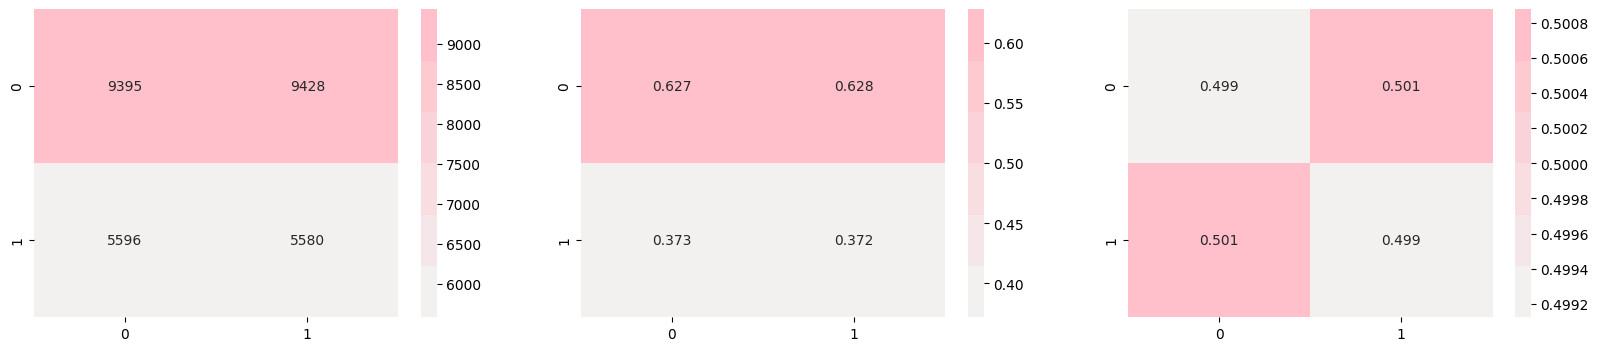

Precision Score: 0.3718017057569296
Recall Score (Sensitivity): 0.4992841803865426
Log loss on test data using a random model: 0.8871143676952112


In [29]:
display_confusion_matrix(y_test, y_test_pred_labels)
print(f"Log loss on test data using a random model: {log_loss(y_test, y_test_pred)}")

## Logistic Regression with Hyperparameter Tuning (L2 Regularizer)

Alpha: 0.1 Log Loss: 0.5050731544022334


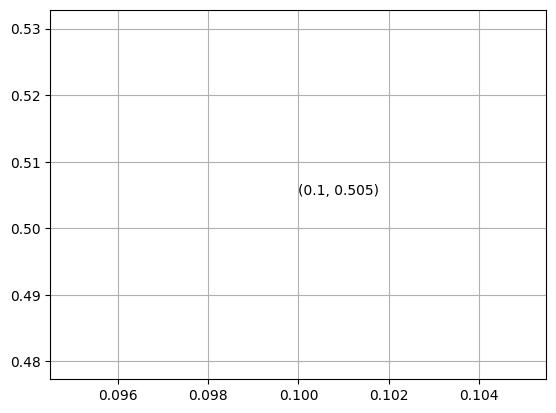

Best Model
 Alpha: 0.1
 Test Error: 0.5050731544022334


In [34]:
log_loss_arr = []
alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
best_model = None

def train_model():
  for alpha in alpha_values:
    train_my_model(alpha)

  fig, ax = plt.subplots()
  ax.plot(alpha_values, log_loss_arr, c="pink")
  for i, loss in enumerate(log_loss_arr):
    ax.annotate((alpha_values[i], np.round(loss, 3)), (alpha_values[i], loss))
  plt.grid()
  plt.title = "Alpha value and its corresponding log loss"
  plt.xlabel = "Alpha"
  plt.ylabel = "Log Loss"
  plt.show()

  print("Best Model")
  index = np.argmin(log_loss_arr)
  print(f" Alpha: {alpha_values[index]}")
  print(f" Training Error: {get_loss(best_model, X_train, y_train)}")
  print(f" Test Error: {log_loss_arr[index]}")
  y_test_pred_label = np.argmax(best_model.predict_proba(y_test), axis=1)
  display_confusion_matrix(y_test, y_test_pred_label)

def train_my_model(alpha_val=0.1):
  best_loss = 1000
  # imputer_knn = KNNImputer(n_neighbors=2)
  clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=alpha_val, random_state=42)
  # pipeline_knn = Pipeline([
  #     ('imputer', imputer_knn),
  #     ('scaler', StandardScaler()),
  #     ('classifier', clf)
  # ])
  clf.fit(X_train, y_train)
  sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
  sig_clf.fit(X_train, y_train)
  loss = get_loss(sig_clf, X_test, y_test)
  if loss < best_loss:
    best_loss = loss
    best_model = deepcopy(sig_clf)
  log_loss_arr.append(loss)
  print(f"Alpha: {alpha_val} Log Loss: {loss}")

def get_loss(model, X, y):
  y_pred = model.predict_proba(X)
  return log_loss(y, y_pred)

# Start model training
train_model()